In [2]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import read_geolife
import tracers as tr
import matplotlib.pyplot as plt
from pyproj import Transformer
import math
import seaborn as sns
import os

In [107]:
traces = []
processed_traces = []  

root_path = "/mnt/d/romataxi"

for i in range(100):
    user_path = f'{i}.csv'
    file_path = os.path.join(root_path, user_path)
    if os.path.exists(file_path):
        df = pd.read_csv(file_path, sep=",")
        traces.append(df) 

for trace_df in traces:
    # Convert timestamp to epoch, with invalid timestamps set to NaT
    trace_df["Timestamp"] = pd.to_datetime(trace_df["Timestamp"], format="ISO8601", errors="coerce").astype(int) / 10**9

    # Drop rows where Timestamp is NaT (invalid timestamps)
    trace_df = trace_df.dropna(subset=["Timestamp"])

    # Sort by time
    trace_df = trace_df.sort_values(by='Timestamp')

    # Convert to array (Longitude, Latitude, Timestamp)
    trace = trace_df[['Longitude', 'Latitude', 'Timestamp']].to_numpy()

    #take only the first 5000 points
    trace = trace[:10000]

    # Convert to list of tuples
    trace = [tuple(x) for x in trace]
    trace = [(x[0], x[1], int(x[2])) for x in trace]
    processed_traces.append(trace)

traces = processed_traces
print(f"Number of traces: {len(traces)}")

Number of traces: 75


In [108]:
(space_noise, time_min_period) = (110.0, 90)
#Picker string 'closest' 
perturbed_traces = tr.perturb_traces((space_noise, time_min_period), traces)

In [ ]:
lat_meter_per_degree = tr.rs_geodesic_distance((41.9028, 12.4964),(41.9028, 12.4965)) * 10000
lon_meter_per_degree = tr.rs_geodesic_distance((41.9028, 12.4964),(41.9029, 12.4964)) * 10000
print("50 meter lat is: ", 50/lat_meter_per_degree, "°")
print("50 meter lon is: ", 50/lon_meter_per_degree, "°")
meter_per_degree = (lat_meter_per_degree + lon_meter_per_degree)/2

10 meter lat is:  0.0004519721625448495 °
10 meter lon is:  0.00045998446106921415 °


In [119]:
from scipy import stats
lat_noise = []
lon_noise = []
angles = []
noise_distr = []

wgs84_to_utm = Transformer.from_crs(4326, 3065, always_xy=True)

for trace_idx in range(len(traces)):
    for point_idx in range(len(traces[trace_idx])):

        perturbed_traces_lon,perturbed_traces_lat = perturbed_traces[trace_idx][point_idx][0], perturbed_traces[trace_idx][point_idx][1]
        traces_lon,traces_lat = traces[trace_idx][point_idx][0], traces[trace_idx][point_idx][1]

        #simulate gps noise with a standard deviation of 10 meter
        noise_lon = np.random.normal(0,0.00045998446106921415) 
        noise_lat = np.random.normal(0,0.0004519721625448495)  

        # Calculate the perturbed traces with noise
        perturbed_lon = perturbed_traces_lon + noise_lon
        perturbed_lat = perturbed_traces_lat + noise_lat
        
        noise = tr.rs_geodesic_distance((perturbed_lon,perturbed_lat),(traces_lon,traces_lat))
        noise_distr.append(noise)

Weibull Distribution Shape: 2.072288277341988
Weibull Distribution Location: -0.3794341414031397
Weibull Distribution Scale: 89.65717529589725


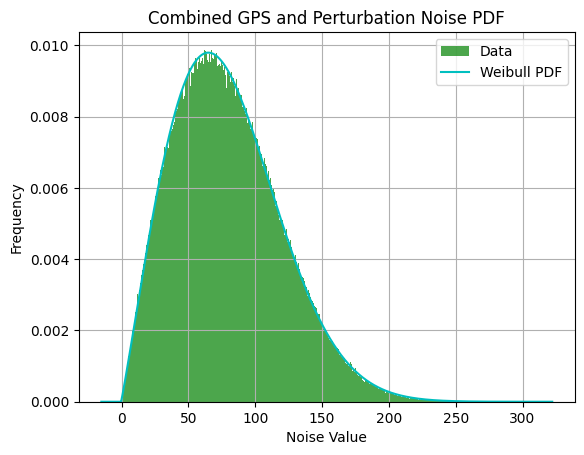

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import weibull_min

params_weibull = weibull_min.fit(noise_distr)  # Weibull distribution
plt.hist(noise_distr, bins=500, density=True, color='g', alpha=0.7, label='Data')

# Overlay fitted distributions
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)

plt.plot(x, weibull_min.pdf(x, *params_weibull), 'c-', label='Weibull PDF')

# Extract and print the parameters for the Weibull distribution
shape_weibull, loc_weibull, scale_weibull = params_weibull
print(f"Weibull Distribution Shape: {shape_weibull}")
print(f"Weibull Distribution Location: {loc_weibull}")
print(f"Weibull Distribution Scale: {scale_weibull}")
plt.title('Combined GPS and Perturbation Noise PDF')
plt.xlabel('Noise Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


### Noise angle

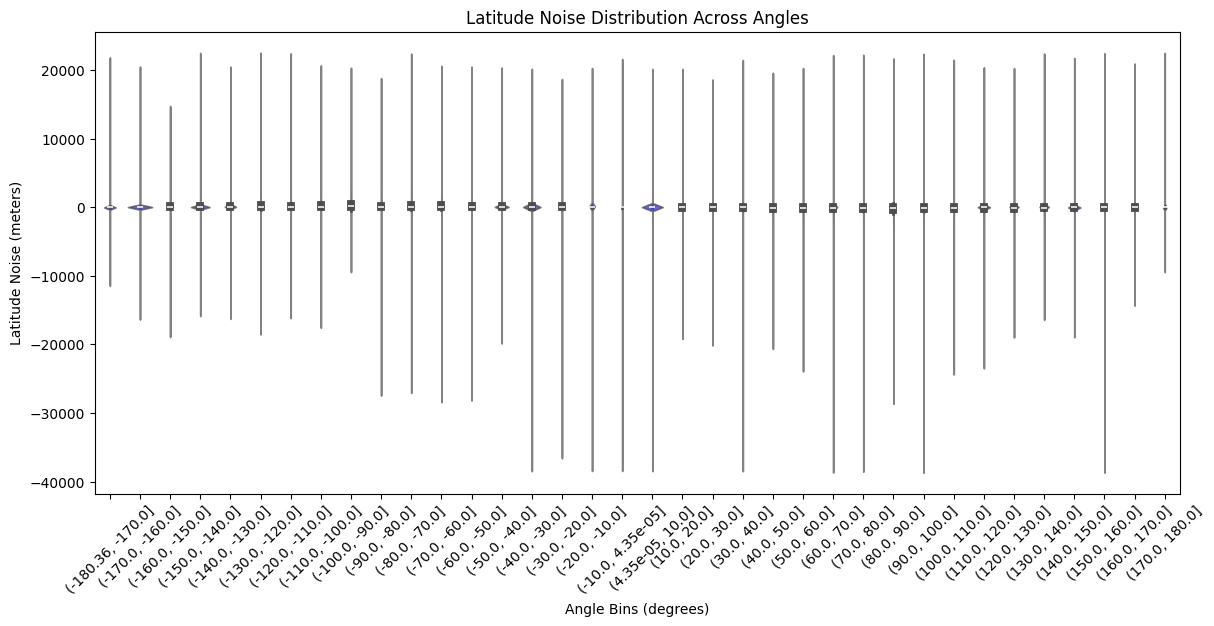

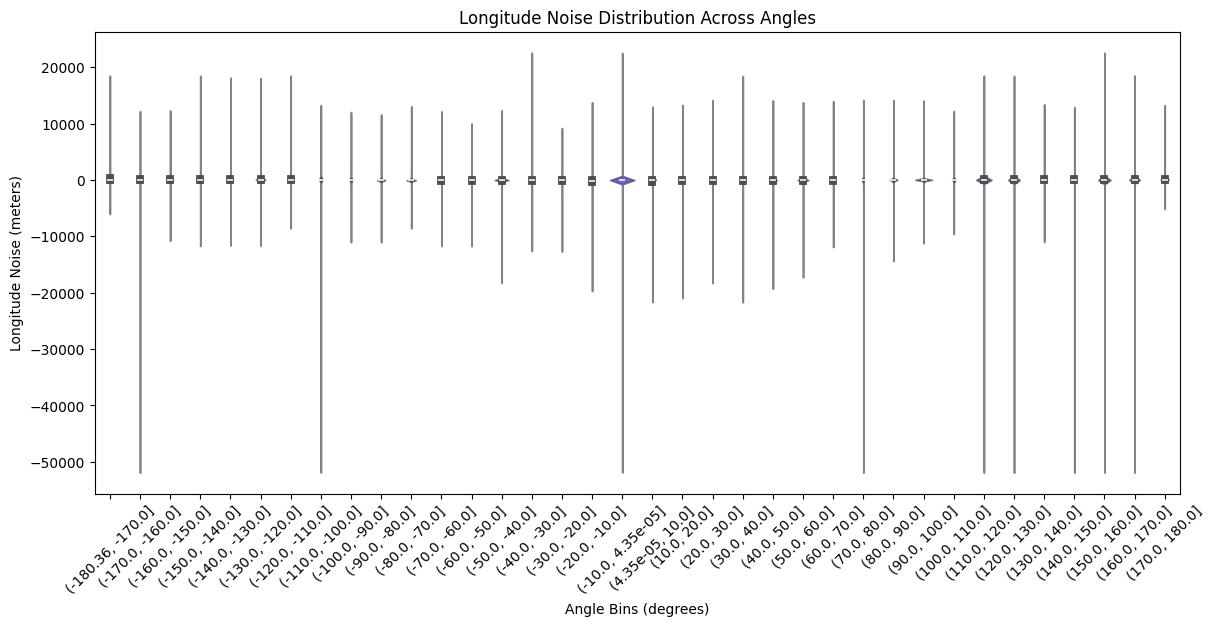

In [19]:
angles_deg = np.degrees(angles)

# Violin plot to show distribution
plt.figure(figsize=(14, 6))
sns.violinplot(x=pd.cut(angles_deg, bins=36), y=lat_noise, color="blue", alpha=0.7)
plt.xlabel("Angle Bins (degrees)")
plt.ylabel("Latitude Noise (meters)")
plt.title("Latitude Noise Distribution Across Angles")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(14, 6))
sns.violinplot(x=pd.cut(angles_deg, bins=36), y=lon_noise, color="blue", alpha=0.7)
plt.xlabel("Angle Bins (degrees)")
plt.ylabel("Longitude Noise (meters)")
plt.title("Longitude Noise Distribution Across Angles")
plt.xticks(rotation=45)
plt.show()


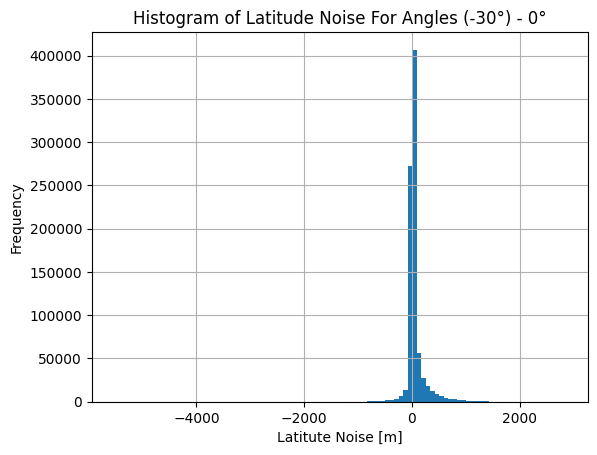

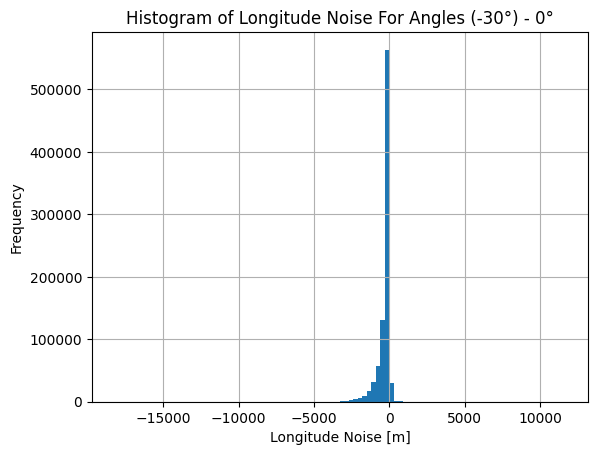

In [ ]:
#angle range
angle_min = -30
angle_max = 0

selected_indices = (angles_deg >= angle_min) & (angles_deg < angle_max)
selected_lon_noise = np.array(lon_noise)[selected_indices]
selected_lat_noise = np.array(lat_noise)[selected_indices]

plt.hist(selected_lat_noise, bins=100)
plt.xlabel("Latitute Noise [m]")
plt.ylabel("Frequency")
plt.title(f"Histogram of Latitude Noise For Angles ({angle_min}°) - {angle_max}°")
plt.grid()
plt.show()

plt.hist(selected_lon_noise, bins=100)
plt.xlabel("Longitude Noise [m]")
plt.ylabel("Frequency")
plt.title(f"Histogram of Longitude Noise For Angles ({angle_min}°) - {angle_max}°")
plt.grid()
plt.show()


/home/dieter/thesis/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/tmp/ipykernel_753/358299559.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


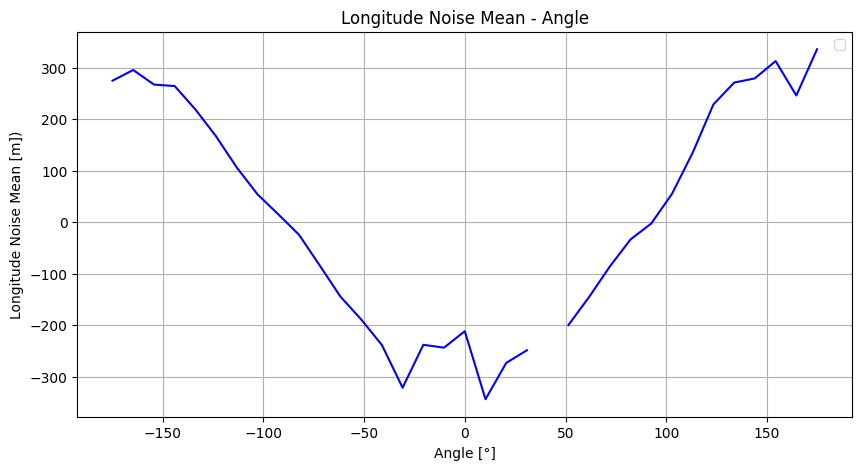

/tmp/ipykernel_753/358299559.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


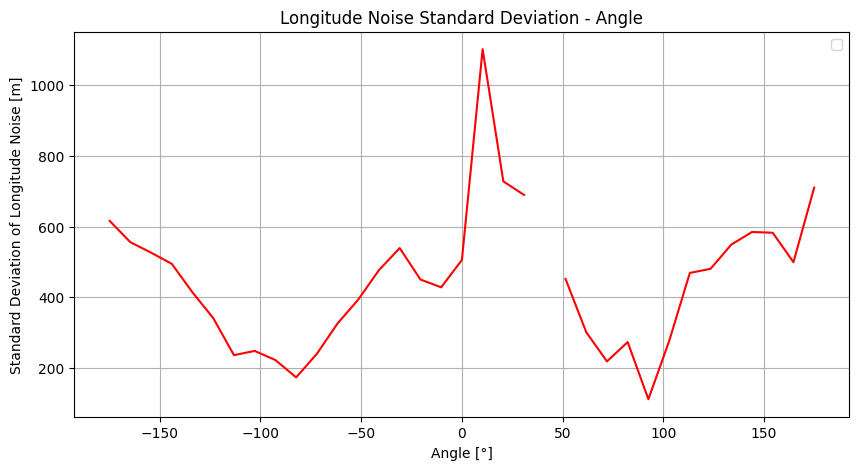

/tmp/ipykernel_753/358299559.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


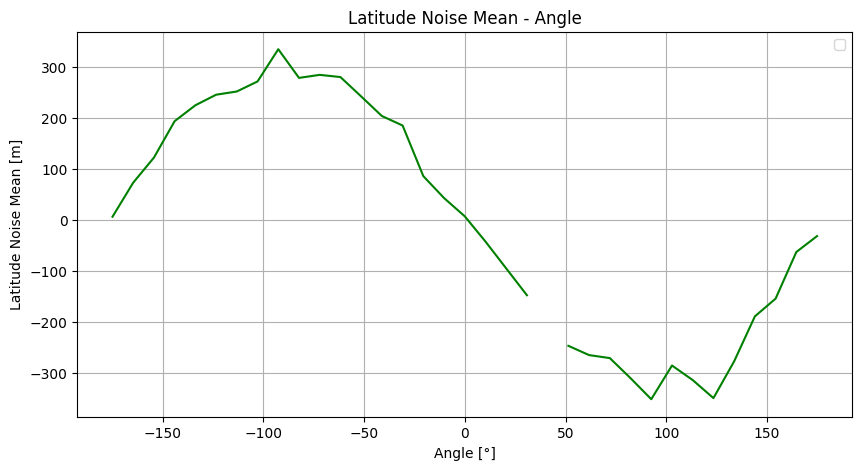

/tmp/ipykernel_753/358299559.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


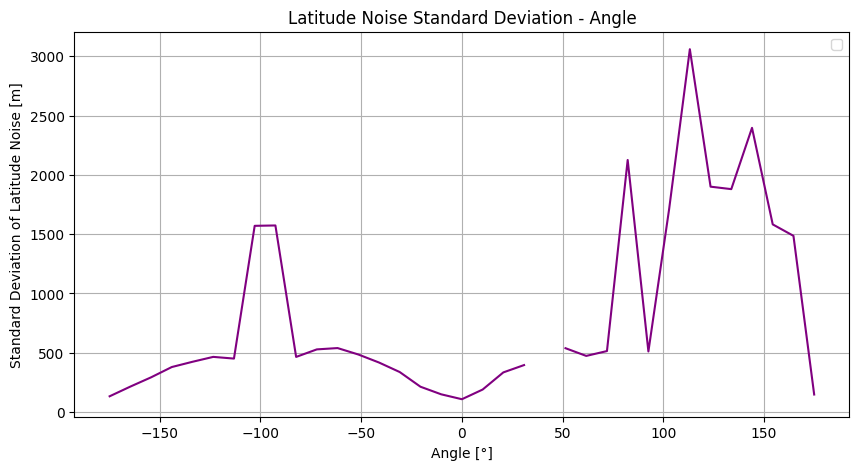

In [ ]:
# Define angle bins
num_bins = 36  
angle_bins = np.linspace(min(angles_deg), max(angles_deg), num_bins)
angle_indices = np.digitize(angles_deg, angle_bins) - 1  


angle_bin_centers = (angle_bins[:-1] + angle_bins[1:]) / 2
lon_means, lon_std_devs, lat_means, lat_std_devs = [], [], [], []

for i in range(len(angle_bin_centers)):
    lon_values_in_bin = [lon_noise[j] for j in range(len(lon_noise)) if angle_indices[j] == i]
    lat_values_in_bin = [lat_noise[j] for j in range(len(lat_noise)) if angle_indices[j] == i]
    
    if len(lon_values_in_bin) > 1:  
        lon_means.append(np.mean(lon_values_in_bin))
        lon_std_devs.append(np.std(lon_values_in_bin))
    if len(lat_values_in_bin) > 1:
        lat_means.append(np.mean(lat_values_in_bin))
        lat_std_devs.append(np.std(lat_values_in_bin))

#longitude noise
plt.figure(figsize=(10, 5))
plt.plot(angle_bin_centers, lon_means, color="blue")
plt.xlabel("Angle [°]")
plt.ylabel("Longitude Noise Mean [m])")
plt.title("Longitude Noise Mean - Angle")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(angle_bin_centers, lon_std_devs, color="red")
plt.xlabel("Angle [°]")
plt.ylabel("Standard Deviation of Longitude Noise [m]")
plt.title("Longitude Noise Standard Deviation - Angle")
plt.legend()
plt.grid()
plt.show()

#latitude noise 
plt.figure(figsize=(10, 5))
plt.plot(angle_bin_centers, lat_means, color="green")
plt.xlabel("Angle [°]")
plt.ylabel("Latitude Noise Mean [m]")
plt.title("Latitude Noise Mean - Angle")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(angle_bin_centers, lat_std_devs, color="purple")
plt.xlabel("Angle [°]")
plt.ylabel("Standard Deviation of Latitude Noise [m]")
plt.title("Latitude Noise Standard Deviation - Angle")
plt.legend()
plt.grid()
plt.show()

